Positive advection speed:[ 1.  3.  5.]
Negative advection speed:[ 2.  4.  6.]
Choose your initial condition 2



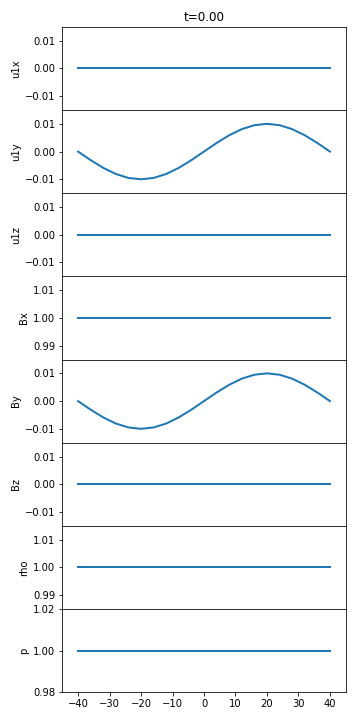
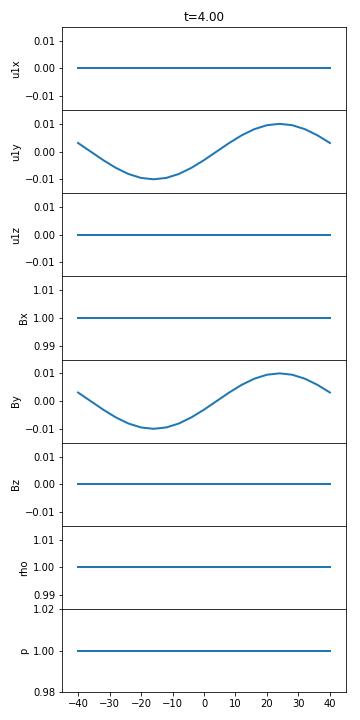
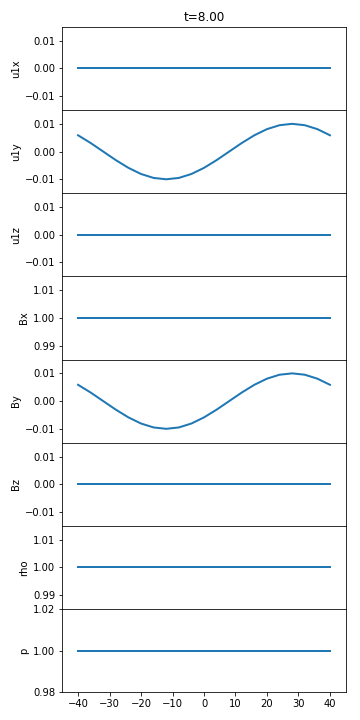
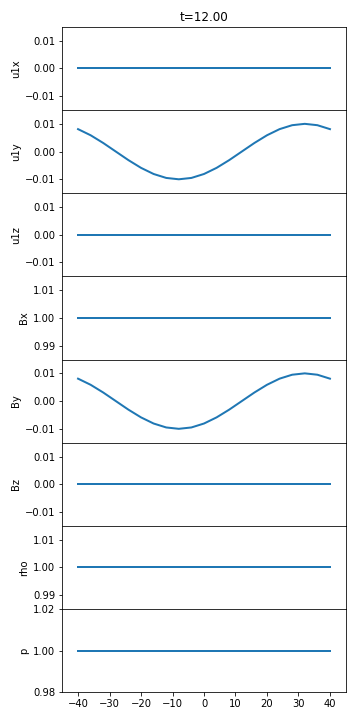
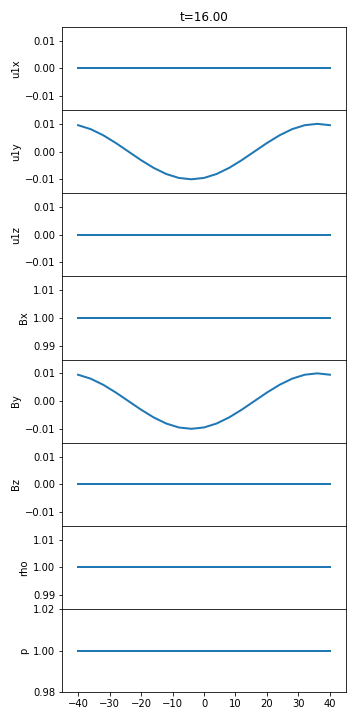
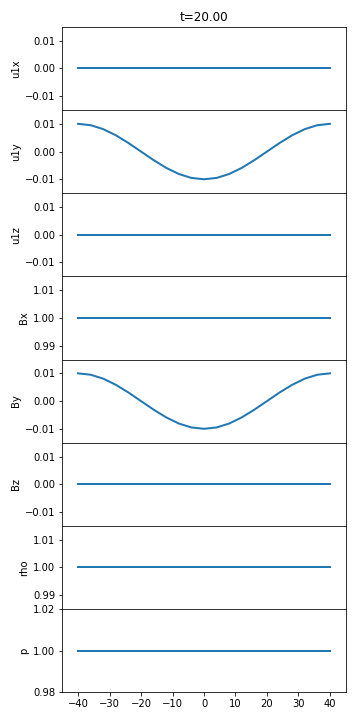
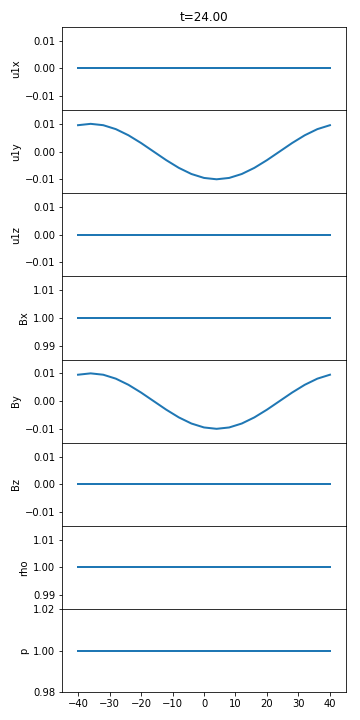
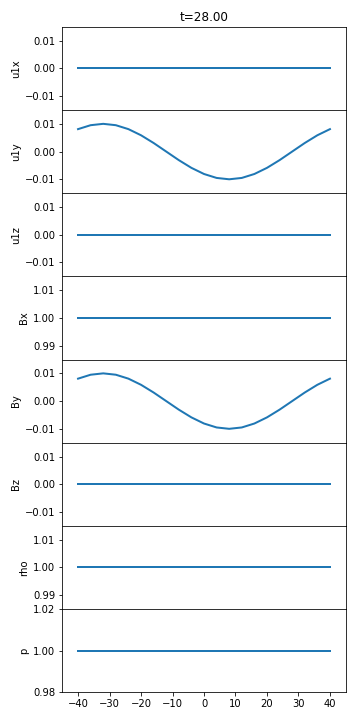
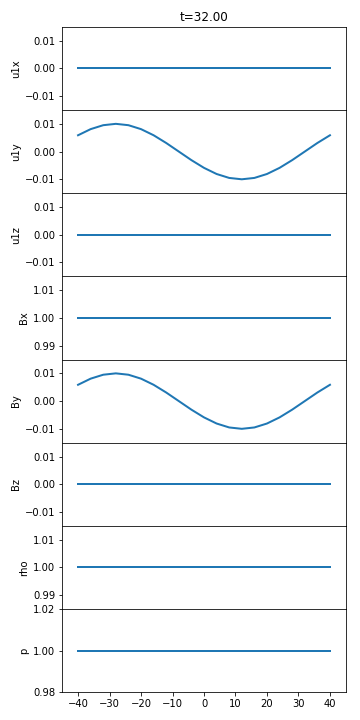
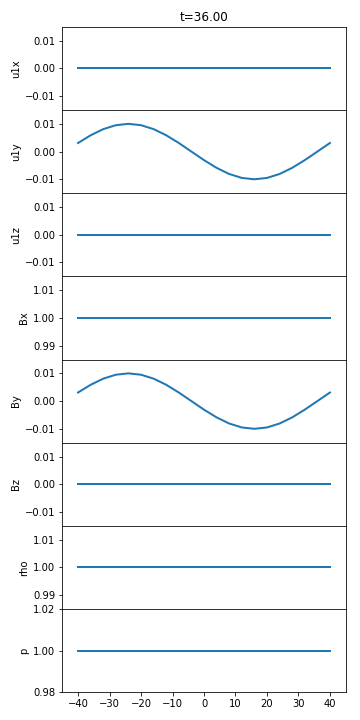
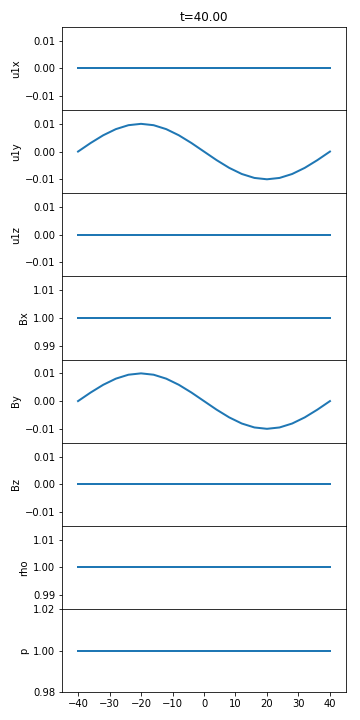
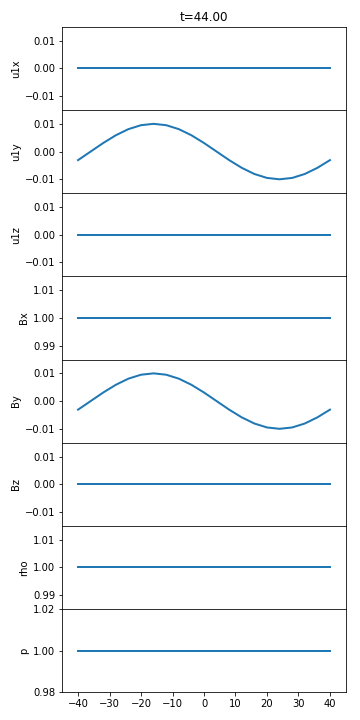
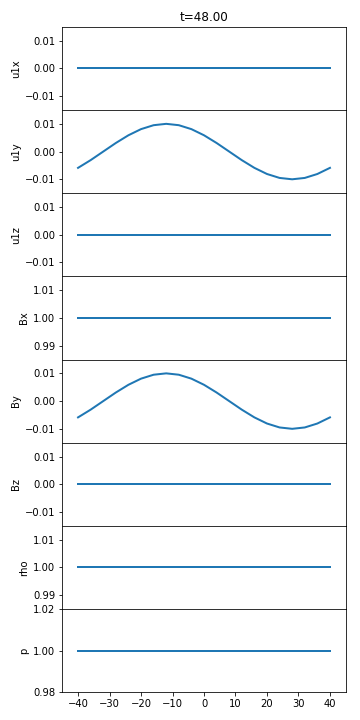
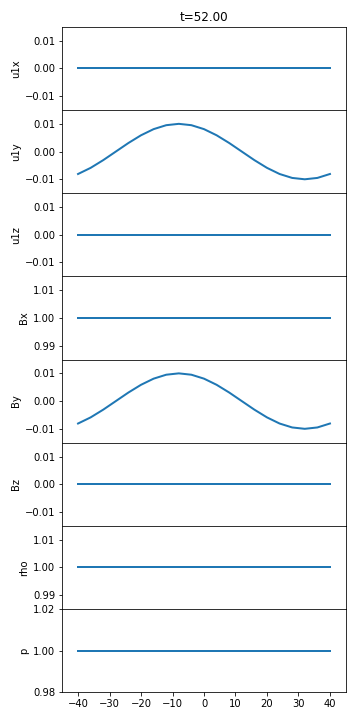
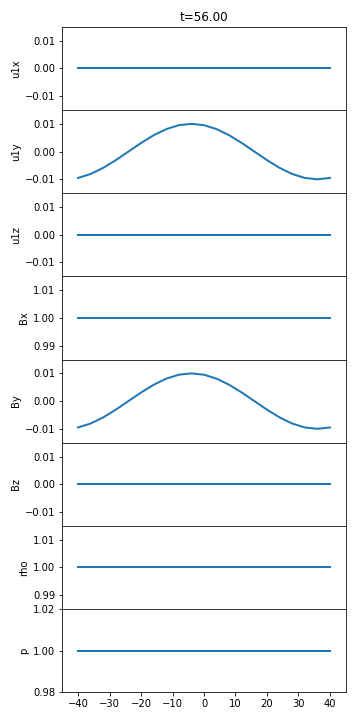
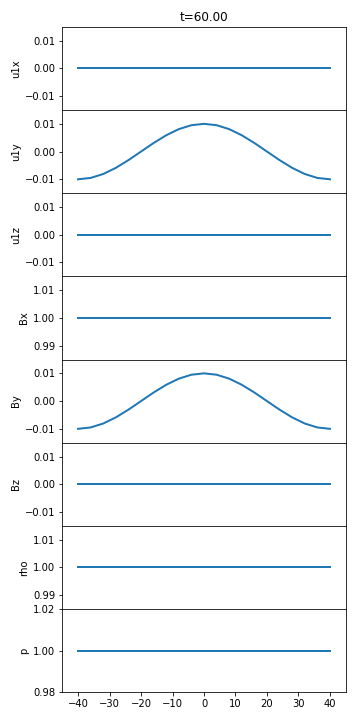
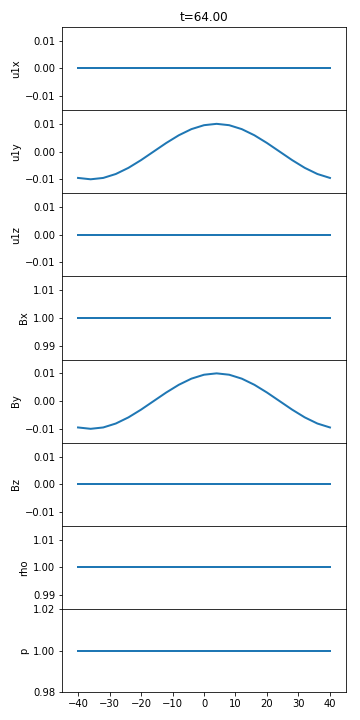
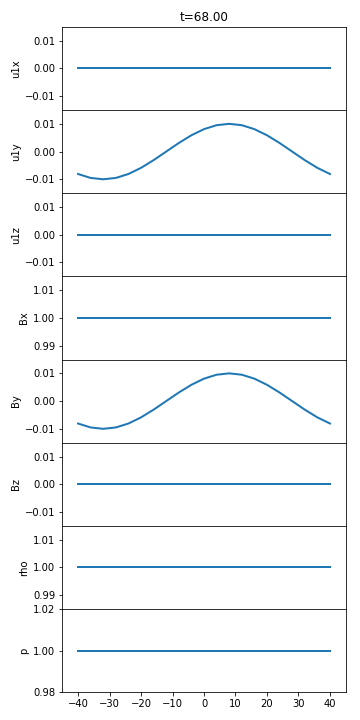
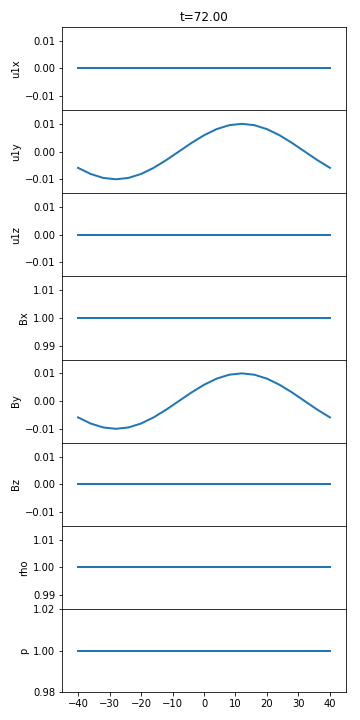
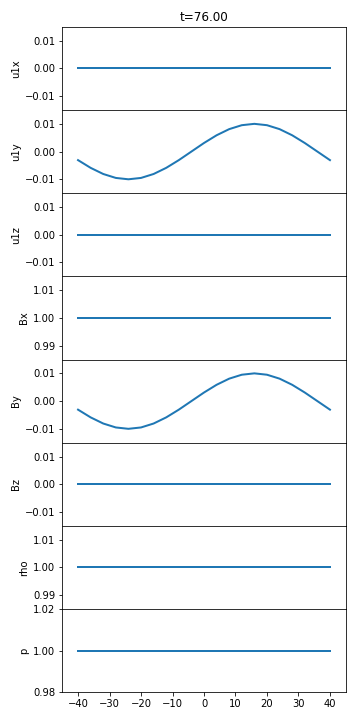
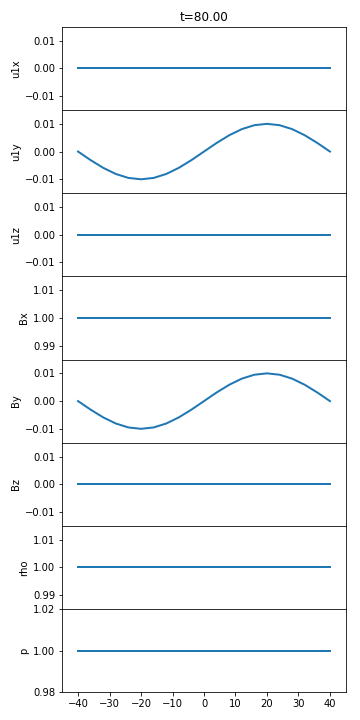
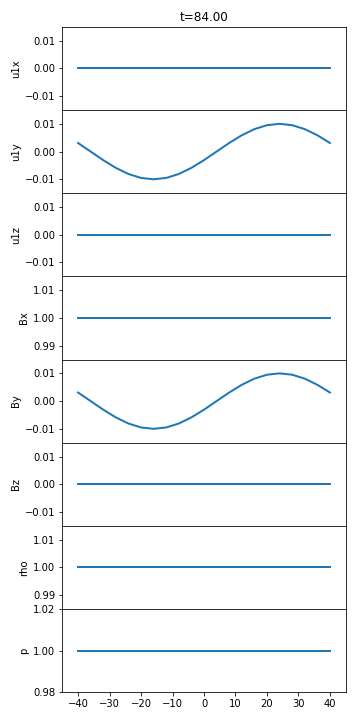
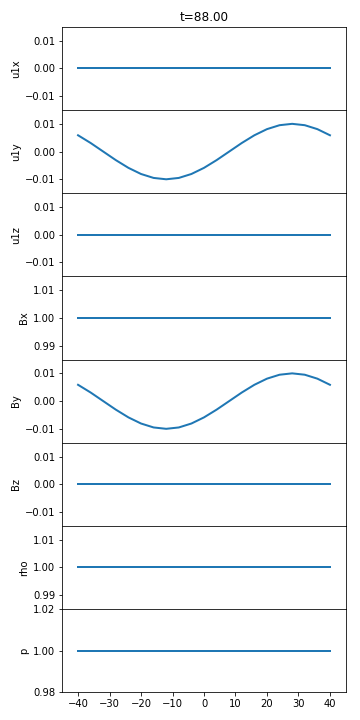
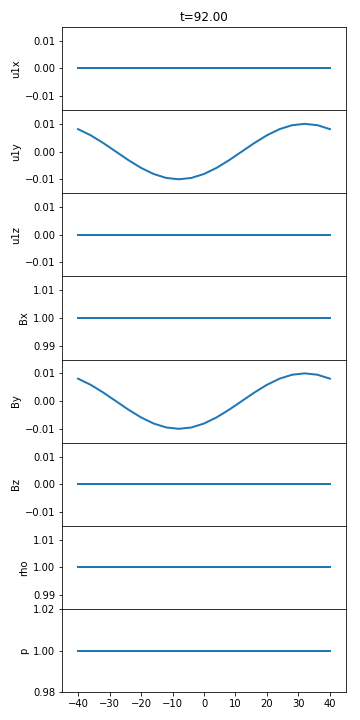
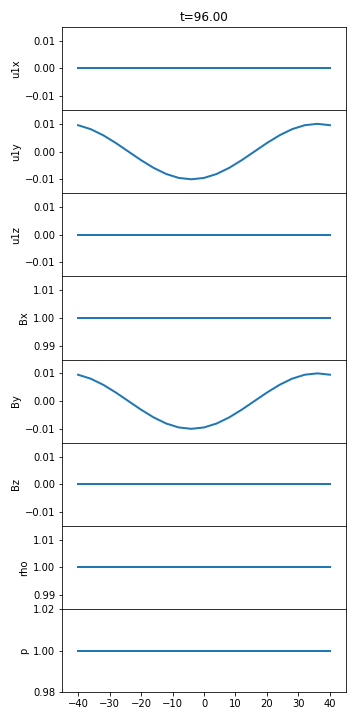
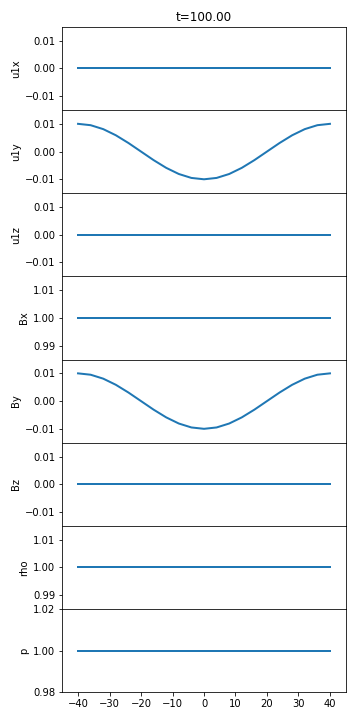

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib import animation
from scipy.linalg import block_diag
from numpy.linalg import inv
from numpy import linalg as LA



#This script contains different methods for simulating linear Alfvén and sound waves in 1D in a homogeneous plasma with mass density rho0 and pressure p0
#which is located in a homogeneous magnetic field B0
#Author: Florian Holderied




#Parameters
rho0=1;       #Mass density of plasma
p0=1;         #Pressure of plasma
B0x=1;        #Background magnetic field x
B0y=0;        #Background magnetic field y
B0z=0;        #Background magnetic field z
gamma=5/3;    #Adiabatic exponent
a=0.01;       #Amplitude of largest pertubation
L=40;         #Length of x-domain in + and - direction (L_tot=2L)
T=100;        #Simulation time
Nx=20;        #Number of cells in x-direction
CFL=1;        #CFL-condition

#System matrix
A=np.array([[0,0,0,0,B0y/rho0,B0z/rho0,0,1/(2*rho0)],[0,0,0,0,-B0x/rho0,0,0,0],[0,0,0,0,0,-B0x/rho0,0,0],[0,0,0,0,0,0,0,0],[B0y,-B0x,0,0,0,0,0,0],[B0z,0,-B0x,0,0,0,0,0],[rho0,0,0,0,0,0,0,0],[p0*gamma,0,0,0,0,0,0,0]]);







#Eigenvalues (Advection speed) and eigenvectors (initial conditions)
v,w=LA.eig(A);
indicespos=np.array([]);
indicesneg=np.array([]);


#Sort by positve and negative advection speeds
for i in range(0,v.size):
    if v[i]>0:
        indicespos=np.append(indicespos,i);
    elif v[i]<0:
        indicesneg=np.append(indicesneg,i);
        

#Choice of initial condition        
print('Positive advection speed:'+str(indicespos))
print('Negative advection speed:'+str(indicesneg))
initial=int(input("Choose your initial condition ")) 


#Normalisation of inital condition
U0=a*w[:,initial]/np.amax(abs(w[:,initial]));
v=v[initial];



#Initial condition for Finite DIfferences
def initialConditions(x):
    return np.outer(U0,np.sin(x*np.pi/L));


#Initial condition for Finite Volumes
def initialVolAverages(x):
    deltax=2*L/Nx;
    result=np.zeros((3,Nx));
    U0new=np.array([U0[0],U0[5],U0[6]]); #ux,rho,p
    for i in range(0,x.size-1):
        result[0,i]=-U0new[1]*L/(np.pi*deltax)*(np.cos(x[i+1]*np.pi/L)-np.cos(np.pi*x[i]/L))+rho0;
        result[1,i]=-rho0*U0new[0]*L/(np.pi*deltax)*(np.cos(x[i+1]*np.pi/L)-np.cos(np.pi*x[i]/L))+1/deltax*U0new[0]*U0new[1]*(x[i+1]/2-L/(4*np.pi)*np.sin(x[i+1]*2*np.pi/L)-x[i]/2+L/(4*np.pi)*np.sin(x[i]*2*np.pi/L));
        result[2,i]=-U0new[2]*L/(np.pi*deltax)*(np.cos(x[i+1]*np.pi/L)-np.cos(np.pi*x[i]/L))+p0;
        
    return result





    
       
#Explicit upwind scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def explicitEulerUpwind(L,T,Nx,CFL,A,v,initialConditions):
    deltax=2*L/Nx;
    deltat=CFL*deltax/np.abs(v);
    Nt=np.int(T/deltat);
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1);
    s=int(np.sqrt(A.size));
    U=np.zeros((Nx,s,Nt+1));
    IC=initialConditions(x);
    U[:,:,0]=np.transpose(IC);
    U=np.reshape(U,(s*Nx,Nt+1));
    
    if v>0:
        B=deltat/deltax*A;
        Tr=block_diag(*([np.identity(s)-B]*Nx))
        F=block_diag(*([B]*(Nx-1)))
        Tr[s:s*Nx,0:s*Nx-s]=F;
        Tr[0:s,-s:s*Nx]=B;
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n]);
            
    elif v<0:
        B=deltat/deltax*A;
        Tr=block_diag(*([np.identity(s)+B]*Nx))
        F=block_diag(*([-B]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx]=F;
        Tr[-s:s*Nx,0:s]=-B;
        
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n]);
    
    Temp=np.zeros((s*Nx+s,Nt+1));
    Temp[0:s*Nx,:]=U;
    Temp[s*Nx:s*Nx+s]=U[0:s,:];
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1));
    
    return Temp




#Implicit upwind scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def implicitEulerUpwind(L,T,Nx,CFL,A,v,initialConditions):
    deltax=2*L/Nx;
    deltat=CFL*deltax/np.abs(v);
    Nt=np.int(T/deltat);
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1);
    s=int(np.sqrt(A.size));
    U=np.zeros((Nx,s,Nt+1));
    IC=initialConditions(x);
    U[:,:,0]=np.transpose(IC);
    U=np.reshape(U,(s*Nx,Nt+1));
    
    if v>0:
        B=deltat/deltax*A;
        Tr=block_diag(*([np.identity(s)-B]*Nx))
        F=block_diag(*([B]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx]=F;
        Tr[-s:s*Nx,0:s]=B;
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(inv(Tr),U[:,n]);
            
    elif v<0:
        B=deltat/deltax*A;
        Tr=block_diag(*([np.identity(s)+B]*Nx))
        F=block_diag(*([-B]*(Nx-1)))
        Tr[s:s*Nx,0:s*Nx-s]=F;
        Tr[0:s,-s:s*Nx]=-B;
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(inv(Tr),U[:,n]);      
                
    Temp=np.zeros((s*Nx+s,Nt+1));
    Temp[0:s*Nx,:]=U;
    Temp[s*Nx:s*Nx+s]=U[0:s,:];
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1));
    
    return Temp





#Lax-Friedrichs scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def LaxFriedrichs(L,T,Nx,CFL,A,v,initialConditions):
    deltax=2*L/Nx;
    deltat=CFL*deltax/np.abs(v);
    Nt=np.int(T/deltat);
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1);
    s=int(np.sqrt(A.size));
    U=np.zeros((Nx,s,Nt+1));
    IC=initialConditions(x);
    U[:,:,0]=np.transpose(IC);
    U=np.reshape(U,(s*Nx,Nt+1));
    
    if v>0:
        B=deltat/(2*deltax)*A;
        B1=0.5*np.identity(s)-B;
        B2=0.5*np.identity(s)+B;
        Tr=np.zeros((s*Nx,s*Nx));
        F1=block_diag(*([B1]*(Nx-1)))
        F2=block_diag(*([B2]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx]=F1;
        Tr[-s:s*Nx,0:s]=B1;
        Tr[s:s*Nx,0:s*Nx-s]=F2;
        Tr[0:s,-s:s*Nx]=B2;
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n]);
            
    elif v<0:
        B=deltat/(2*deltax)*A;
        B1=0.5*np.identity(s)+B;
        B2=0.5*np.identity(s)-B;
        Tr=np.zeros((s*Nx,s*Nx));
        F1=block_diag(*([B1]*(Nx-1)))
        F2=block_diag(*([B2]*(Nx-1)))
        Tr[0:s*Nx-s,s:s*Nx]=F1;
        Tr[-s:s*Nx,0:s]=B1;
        Tr[s:s*Nx,0:s*Nx-s]=F2;
        Tr[0:s,-s:s*Nx]=B2;
    
        for n in range(0,U[0,:].size-1):
            U[:,n+1]=np.dot(Tr,U[:,n]);
            
    Temp=np.zeros((s*Nx+s,Nt+1));
    Temp[0:s*Nx,:]=U;
    Temp[s*Nx:s*Nx+s]=U[0:s,:];
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1));
    
    return Temp







#Lax-Wendroff scheme with matrix notation U=(u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1)
def LaxWendroff(L,T,Nx,CFL,A,v,initialConditions):
    deltax=2*L/Nx;
    deltat=CFL*deltax/np.abs(v);
    Nt=np.int(T/deltat);
    x=np.linspace(-L,L,Nx+1)
    x=np.delete(x,-1);
    s=int(np.sqrt(A.size));
    U=np.zeros((Nx,s,Nt+1));
    IC=initialConditions(x);
    U[:,:,0]=np.transpose(IC);
    U=np.reshape(U,(s*Nx,Nt+1));
    
    B1=np.identity(s)-((deltat/deltax)**2)*np.dot(A,A);
    B2=(0.5*(deltat/deltax)**2)*np.dot(A,A)-np.sign(v)*(deltat/(2*deltax))*A;
    B3=(0.5*(deltat/deltax)**2)*np.dot(A,A)+np.sign(v)*(deltat/(2*deltax))*A;
    
    Tr=block_diag(*([B1]*Nx))
    F1=block_diag(*([B2]*(Nx-1))) 
    F2=block_diag(*([B3]*(Nx-1))) 
    Tr[0:s*Nx-s,s:s*Nx]=F1;
    Tr[-s:s*Nx,0:s]=B2;
    Tr[s:s*Nx,0:s*Nx-s]=F2;
    Tr[0:s,-s:s*Nx]=B3;
    
    for n in range(0,U[0,:].size-1):
        U[:,n+1]=np.dot(Tr,U[:,n]);
        
    Temp=np.zeros((s*Nx+s,Nt+1));
    Temp[0:s*Nx,:]=U;
    Temp[s*Nx:s*Nx+s]=U[0:s,:];
    Temp=np.reshape(Temp,(Nx+1,s,Nt+1));
    
    return Temp








def nonlinearSoundWave(L,T,Nx,CFL,v,initialVolAverages):
    deltax=2*L/Nx;
    deltat=CFL*deltax/np.abs(v);
    Nt=np.int(T/deltat);
    x=np.linspace(-L,L,Nx+1);
    U=np.zeros((Nt+1,Nx,3));
    IC=initialVolAverages(x);
    U[0,:,0]=IC[0,:];
    U[0,:,1]=IC[1,:];
    U[0,:,2]=IC[2,:];
                                             
    for n in range(0,Nt):
        for j in range(0,Nx):
            U[n+1,j,0]=U[n,j,0]-deltat/deltax*(U[n,j,1]-U[n,j-1,1]);
            U[n+1,j,1]=U[n,j,1]-deltat/deltax*(U[n,j,1]**2/U[n,j,0]+0.5*U[n,j,2]-U[n,j-1,1]**2/U[n,j-1,0]-0.5*U[n,j-1,2]);
            U[n+1,j,2]=U[n,j,2]-deltat/deltax*(U[n,j,1]*U[n,j,2]/U[n,j,0]-U[n,j-1,1]*U[n,j-1,2]/U[n,j-1,0])
              
    return U





#Choose your method

#Test=explicitEulerUpwind(L,T,Nx,CFL,A,v,initialConditions);
#Test=implicitEulerUpwind(L,T,Nx,CFL,A,v,initialConditions);
Test=LaxWendroff(L,T,Nx,CFL,A,v,initialConditions);
#Test=LaxFriedrichs(L,T,Nx,CFL,A,v,initialConditions);    
   

    
    
    
    
    
#Discretisation of space and time for Animation
deltax=2*L/Nx;
deltat=CFL*deltax/np.abs(v);
Nt=np.int(T/deltat);
T=Nt*deltat;
x=np.linspace(-L,L,Nx+1);
t=np.linspace(0,T,Nt+1);


# Animation    
f, (a1, a2, a3, a4, a5, a6, a7, a8) = plt.subplots(8, 1, sharex=True)
f.set_figheight(10)
f.set_figwidth(5)
a1.set_title('t=0.00')
a1.set_xlim((-45,45))
a1.set_ylim((-0.015,0.015))
a2.set_ylim((-0.015,0.015))
a3.set_ylim((-0.015,0.015))
a4.set_ylim((B0x-0.015,B0x+0.015))
a5.set_ylim((B0y-0.015,B0y+0.015))
a6.set_ylim((B0z-0.015,B0z+0.015))
a7.set_ylim((rho0-0.015,rho0+0.015))
a8.set_ylim((p0-0.02,p0+0.02))
a1.set_ylabel('u1x')
a2.set_ylabel('u1y')
a3.set_ylabel('u1z')
a4.set_ylabel('Bx')
a5.set_ylabel('By')
a6.set_ylabel('Bz')
a7.set_ylabel('rho')
a8.set_ylabel('p')
line1,=a1.plot([],[], lw=2)
line2,=a2.plot([],[], lw=2)
line3,=a3.plot([],[], lw=2)
line4,=a4.plot([],[], lw=2)
line5,=a5.plot([],[], lw=2)
line6,=a6.plot([],[], lw=2)
line7,=a7.plot([],[], lw=2)
line8,=a8.plot([],[], lw=2)
a4.set_xlabel('x')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

def init():  
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line7.set_data([], [])
    line8.set_data([], [])
    return line1,

def animate(i):
    line1.set_data(x,Test[:,0,i])
    line2.set_data(x,Test[:,1,i])
    line3.set_data(x,Test[:,2,i])
    line4.set_data(x,Test[:,3,i]+B0x)
    line5.set_data(x,Test[:,4,i]+B0y)
    line6.set_data(x,Test[:,5,i]+B0z)
    line7.set_data(x,Test[:,6,i]+rho0)
    line8.set_data(x,Test[:,7,i]+p0)
    a1.set_title('t='+'%.2f' % t[i])
    return line1,

animation.FuncAnimation(f, animate, init_func=init, frames=Nt+1, interval=50, blit=True)